<a href="https://colab.research.google.com/github/jesst0x/image-segmentation-in-dark/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'AI/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [67]:
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import torchvision.utils
import torch
import numpy as np
import random
import json

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Data Augmentation

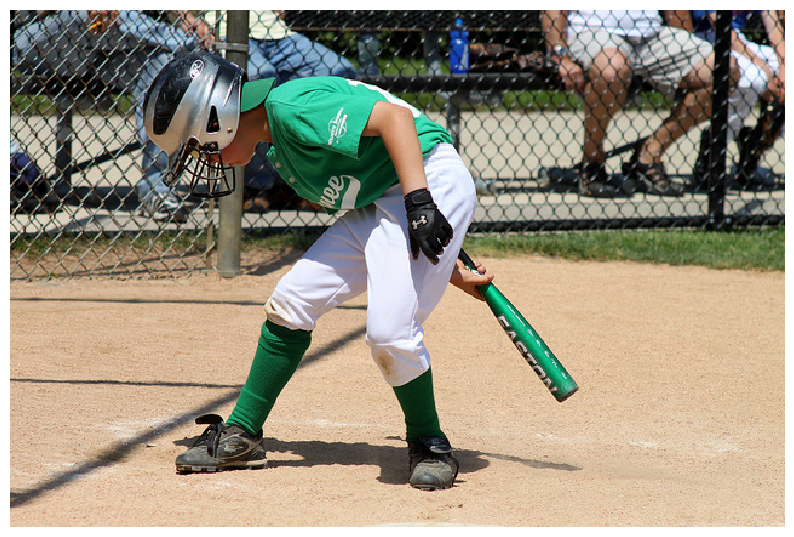

In [46]:
sample_img = Image.open('/content/drive/My Drive/AI/coco/coco_subset100/000000530124.jpg')
plt.axis('off')
plt.imshow(sample_img)

torch.Size([3, 427, 640])
torch.Size([3, 427, 640])
<class 'torch.Tensor'>


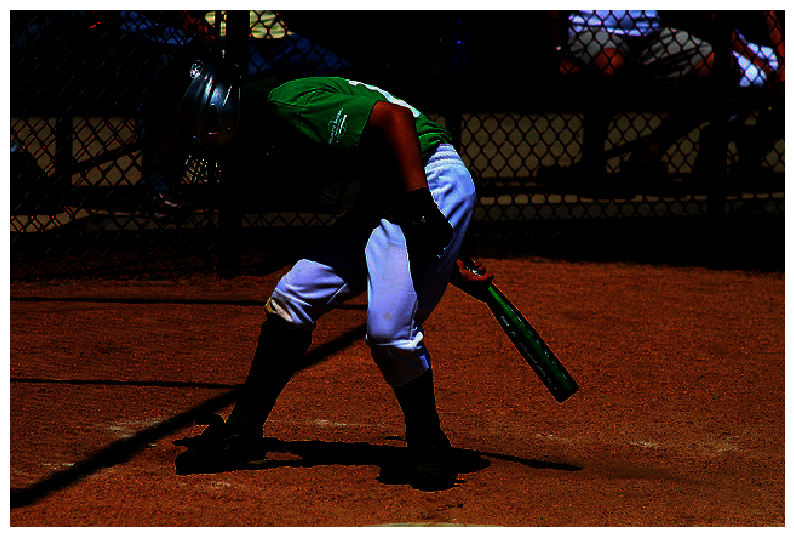

In [155]:
sample_img_tensor = v2.functional.pil_to_tensor(sample_img)
print(sample_img_tensor.shape)
darkened_sample_img = v2.functional.adjust_gamma(sample_img_tensor, gamma=8) / 255.0
print(darkened_sample_img.shape)
plt.axis('off')
plt.imshow(darkened_sample_img.permute(1,2,0))
print(type(darkened_sample_img))

##Darken Image
We apply gamma correction randomly with parameter gamma in range [2, 10) to reduce the brightness of image nonlineary.

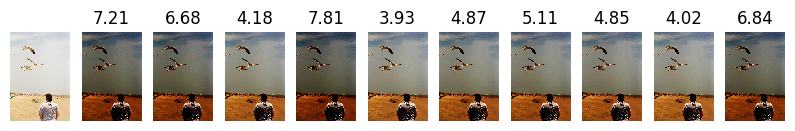

In [36]:
num_image = 10
# Original image
plt.subplot(1, num_image + 1, 1)
plt.imshow(sample_img_tensor.permute(1,2,0))
plt.axis('off')
for i in range(num_image):
  gamma = np.random.uniform(2, 10)
  transform_img = v2.functional.adjust_gamma(sample_img_tensor, gamma=gamma)
  plt.subplot(1,num_image + 1, i + 2)
  plt.imshow(transform_img.permute(1,2,0))
  plt.axis('off')
  plt.title(round(gamma, 2))

plt.show()

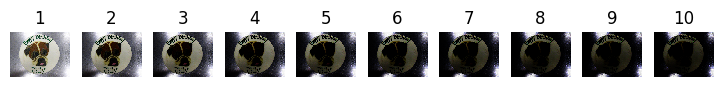

In [22]:
num_gamma = 10
for i in range(num_gamma):
  gamma = i + 1
  transform_img = v2.functional.adjust_gamma(sample_img_tensor, gamma=gamma)
  plt.subplot(1,num_gamma + 1, i + 1)
  plt.imshow(transform_img.permute(1,2,0))
  plt.axis('off')
  plt.title(gamma)

plt.show()

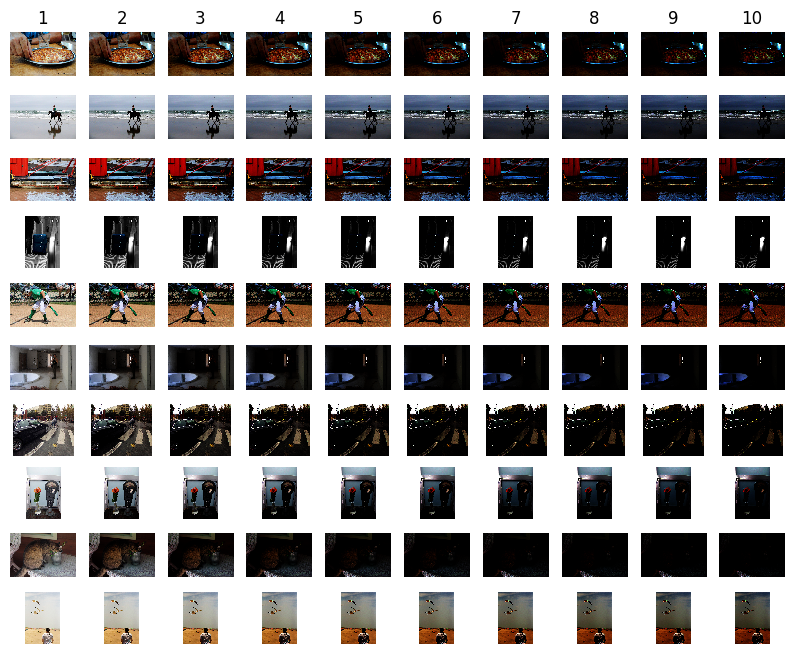

In [24]:
num_image = 10
num_gamma = 10
files = os.listdir('/content/drive/My Drive/AI/coco/coco_subset100')[:num_image]

for i, file in enumerate(files):
  sample_img = Image.open('/content/drive/My Drive/AI/coco/coco_subset100/' + file)
  sample_img_tensor = v2.functional.pil_to_tensor(sample_img)
  for j in range(num_gamma):
    gamma = j + 1
    transform_img = v2.functional.adjust_gamma(sample_img_tensor, gamma=gamma)
    plt.subplot(num_image,num_gamma, i * (num_gamma) + j + 1)
    plt.imshow(transform_img.permute(1,2,0))
    plt.axis('off')
    if i == 0:
      plt.title(gamma)

plt.show()

In [39]:
def adjust_gamma(image_path, gamma=[2, 10]):
  img = Image.open(image_path)
  img_tensor = v2.functional.pil_to_tensor(img)
  gamma = np.random.uniform(gamma[0], gamma[1])
  transform_img = v2.functional.adjust_gamma(img_tensor, gamma=gamma)
  return transform_img, gamma


In [40]:
random.seed(23)

Darken all the real images and save in new directory with same file name. This allows us to use the same COCO annotation json file.

In [43]:
input_dir = '/content/drive/My Drive/AI/coco/coco_subset100'
output_dir = '/content/drive/My Drive/AI/coco/coco_subset100_darkened2'

darkened_summary = {}
files = os.listdir(input_dir)
for file in tqdm(files):
  darkened_img_tensor, gamma = adjust_gamma(os.path.join(input_dir, file))
  darkened_img = v2.functional.to_pil_image(darkened_img_tensor)
  darkened_img.save(os.path.join(output_dir, file))
  darkened_summary[file] = gamma
json.dump(darkened_summary, open(os.path.join(output_dir, 'darkened_summary.json'), 'w'))

100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


## Gaussian Noise


In [49]:
from skimage.util import random_noise

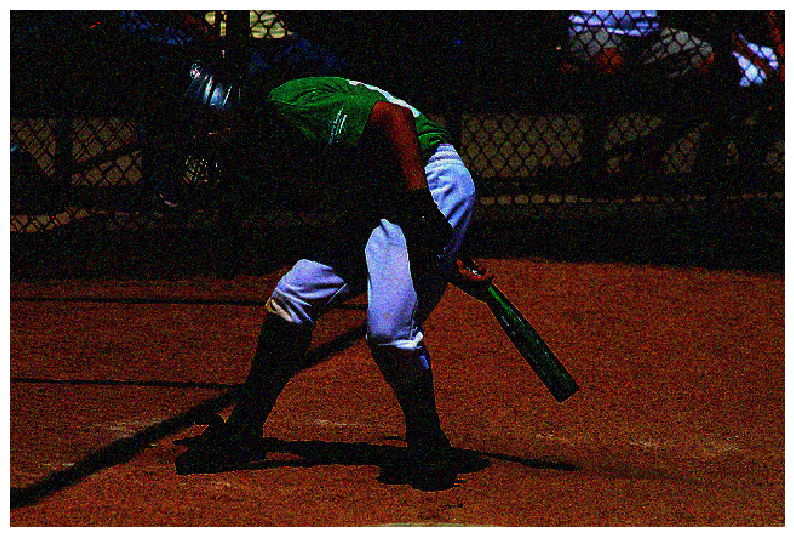

In [163]:
darkened_sample_img_normalize = v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(darkened_sample_img)
sample_noisy_image = random_noise(darkened_sample_img_normalize, var=0.03, clip=True)
sample_noisy_image = torch.tensor(sample_noisy_image * 0.5 + 0.5)
plt.axis('off')
plt.imshow(sample_noisy_image.permute(1,2,0))
# torchvision.utils.save_image(sample_noisy_image, os.path.join('/content/drive/My Drive/AI/coco', 'sample_noisy_image.png'))

In [124]:
def add_gaussian_noise(image_path, var_range=[0.1, 0.5]):
  img = Image.open(image_path)
  img_tensor = v2.functional.pil_to_tensor(img)
  var = np.random.uniform(var_range[0], var_range[1])
  # Normalize to [-1, 1]
  img_normalized = v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img_tensor / 255.0)
  noisy_image = random_noise(img_normalized, var=var, clip=True)
  noisy_image = torch.tensor(noisy_image * 0.5 + 0.5)
  return noisy_image
  # Denormalize

###Finding SNR
Try to find SNR between real normal light image and real low-light image as reference using LIS dataset.

In [72]:
%%capture
!pip install torcheval

In [73]:
import torch
from torcheval.metrics.functional import peak_signal_noise_ratio

In [154]:
snr = peak_signal_noise_ratio(sample_img_tensor/255, darkened_sample_img)
print(snr)
snr = peak_signal_noise_ratio(sample_img_tensor/255, sample_noisy_image)
print(snr)

tensor(6.2969)
tensor(6.6245, dtype=torch.float64)


In [90]:
# SNR of LIS dataset
lis_snr = []
for i in range(100):
  normal_img_path = f'/content/drive/My Drive/AI/lis/{i * 2 + 1}.png'
  low_light_img_path = f'/content/drive/My Drive/AI/lis/{i * 2 + 2}.JPG'
  snr = peak_signal_noise_ratio(v2.functional.pil_to_tensor(Image.open(low_light_img_path)) / 255, v2.functional.pil_to_tensor(Image.open(normal_img_path)) / 255)
  lis_snr.append(snr)
  print(snr)


tensor(13.3129)
tensor(14.4185)
tensor(10.7578)
tensor(12.3798)
tensor(14.6341)
tensor(17.9062)
tensor(12.1396)
tensor(15.1197)
tensor(15.7317)
tensor(10.8975)
tensor(13.8590)
tensor(17.9241)
tensor(13.1559)
tensor(13.1450)
tensor(11.6315)
tensor(10.3713)
tensor(12.5820)
tensor(12.2413)
tensor(9.9111)
tensor(12.0831)
tensor(7.8778)
tensor(14.7008)
tensor(15.2944)
tensor(13.3463)
tensor(13.7239)
tensor(15.7303)
tensor(11.4314)
tensor(13.1989)
tensor(14.1486)
tensor(12.0651)
tensor(16.3057)
tensor(15.9707)
tensor(14.5613)
tensor(14.3422)
tensor(18.7694)
tensor(15.2283)
tensor(15.6142)
tensor(17.5722)
tensor(18.7817)
tensor(15.3087)
tensor(13.9906)
tensor(17.5172)
tensor(15.6270)
tensor(19.9994)
tensor(20.1680)
tensor(12.6061)
tensor(15.6515)
tensor(18.4191)
tensor(15.8790)
tensor(17.6764)
tensor(18.2920)
tensor(15.1061)
tensor(16.5055)
tensor(16.6889)
tensor(14.3146)
tensor(16.2676)
tensor(16.5354)
tensor(12.9675)
tensor(13.9950)
tensor(14.3836)
tensor(17.2560)
tensor(17.1381)
tensor(15.

In [116]:
print(f'LIS Dataset SNR Average: {sum(lis_snr)/len(lis_snr)}, Min: {min(lis_snr)} Max: {max(lis_snr)}, Std: {np.std(lis_snr)}, Median: {np.median(lis_snr)}')

LIS Dataset SNR Average: 15.009089469909668, Min: 7.877816677093506 Max: 20.168010711669922, Std: 2.5055148601531982, Median: 15.143763542175293


In [165]:
input_dir = '/content/drive/My Drive/AI/coco/coco_subset100_darkened2'
output_dir = '/content/drive/My Drive/AI/coco/coco_subset100_augmented'

files = os.listdir(input_dir)
for f in tqdm(files):
  noisy_img = add_gaussian_noise(os.path.join(input_dir, f), [0.01, 0.05])
  torchvision.utils.save_image(noisy_img, os.path.join(output_dir, f))

100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


Compute SNR between real normal light and augmented images.

In [166]:
raw_input_dir = '/content/drive/My Drive/AI/coco/coco_subset100'
augmented_dir = '/content/drive/My Drive/AI/coco/coco_subset100_augmented'

augmented_snr = []
files = os.listdir(augmented_dir)
for f in tqdm(files):
  normal_img_path = os.path.join(raw_input_dir, f)
  low_light_img_path = os.path.join(augmented_dir, f)
  snr = peak_signal_noise_ratio(v2.functional.pil_to_tensor(Image.open(low_light_img_path)) / 255, v2.functional.pil_to_tensor(Image.open(normal_img_path)) / 255)
  augmented_snr.append(snr)
  print(snr)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(7.4676)


  6%|▌         | 6/100 [00:00<00:04, 19.17it/s]

tensor(12.1770)
tensor(7.4360)
tensor(10.5662)
tensor(12.4047)
tensor(8.6889)
tensor(9.6901)
tensor(7.4128)
tensor(8.6625)


 14%|█▍        | 14/100 [00:00<00:02, 29.38it/s]

tensor(7.8288)
tensor(11.3175)
tensor(12.0625)
tensor(7.7534)
tensor(9.2875)
tensor(9.9021)
tensor(12.5252)
tensor(9.7456)


 23%|██▎       | 23/100 [00:00<00:02, 36.12it/s]

tensor(8.0368)
tensor(7.5371)
tensor(6.1477)
tensor(8.5277)
tensor(7.7811)
tensor(12.4863)
tensor(9.5760)


 27%|██▋       | 27/100 [00:01<00:02, 27.60it/s]

tensor(14.6708)
tensor(10.0198)
tensor(12.2725)
tensor(8.9116)


 34%|███▍      | 34/100 [00:01<00:02, 25.60it/s]

tensor(5.4602)
tensor(14.5437)
tensor(7.7092)
tensor(13.0124)
tensor(7.3659)
tensor(8.6418)


 40%|████      | 40/100 [00:01<00:02, 25.48it/s]

tensor(8.4877)
tensor(8.0731)
tensor(10.2087)
tensor(5.3344)
tensor(10.1395)
tensor(6.1313)


 43%|████▎     | 43/100 [00:01<00:02, 25.25it/s]

tensor(8.0610)
tensor(6.9680)
tensor(8.3572)
tensor(9.1973)
tensor(14.1948)


 49%|████▉     | 49/100 [00:02<00:02, 19.30it/s]

tensor(9.1041)
tensor(8.9717)
tensor(6.3614)
tensor(10.6724)
tensor(14.7146)


 57%|█████▋    | 57/100 [00:02<00:01, 24.99it/s]

tensor(8.7752)
tensor(9.7902)
tensor(7.2149)
tensor(9.5987)
tensor(9.5047)
tensor(10.3016)
tensor(6.3775)


 64%|██████▍   | 64/100 [00:02<00:01, 27.52it/s]

tensor(7.7353)
tensor(10.9608)
tensor(6.9507)
tensor(8.3650)
tensor(8.8114)
tensor(8.4748)
tensor(8.0573)


 72%|███████▏  | 72/100 [00:02<00:00, 30.91it/s]

tensor(13.9368)
tensor(8.2844)
tensor(11.9282)
tensor(9.1695)
tensor(9.4003)
tensor(8.8907)
tensor(8.7196)
tensor(9.5769)


 76%|███████▌  | 76/100 [00:02<00:00, 32.06it/s]

tensor(12.1229)
tensor(8.8785)
tensor(11.6322)
tensor(7.6925)
tensor(9.5444)
tensor(8.7856)
tensor(8.5695)


 84%|████████▍ | 84/100 [00:03<00:00, 31.86it/s]

tensor(10.5649)
tensor(10.7205)
tensor(11.1945)
tensor(6.4943)
tensor(11.4259)
tensor(8.0008)
tensor(9.0852)


 92%|█████████▏| 92/100 [00:03<00:00, 32.56it/s]

tensor(7.7629)
tensor(6.1081)
tensor(7.9266)
tensor(12.5589)
tensor(10.9496)
tensor(7.6528)
tensor(7.5528)


100%|██████████| 100/100 [00:03<00:00, 27.13it/s]

tensor(9.4322)
tensor(7.9831)
tensor(7.9075)
tensor(9.5692)
tensor(6.0829)
tensor(6.8086)
tensor(10.9256)


In [167]:
print(f'LIS Dataset SNR Average: {np.mean(augmented_snr)}, Min: {min(augmented_snr)} Max: {max(augmented_snr)}, Std: {np.std(augmented_snr)}, Median: {np.median(augmented_snr)}')

LIS Dataset SNR Average: 9.27363109588623, Min: 5.334362506866455 Max: 14.714608192443848, Std: 2.1015241146087646, Median: 8.8846435546875


In [145]:
# LOL of LIS dataset
lol_snr = []
for f in os.listdir('/content/drive/My Drive/AI/LOL/normal'):
  normal_img_path = os.path.join('/content/drive/My Drive/AI/LOL/normal', f)
  low_light_img_path = os.path.join('/content/drive/My Drive/AI/LOL/low', f.replace("normal", "low"))
  snr = peak_signal_noise_ratio(v2.functional.pil_to_tensor(Image.open(low_light_img_path)) / 255, v2.functional.pil_to_tensor(Image.open(normal_img_path)) / 255)
  lol_snr.append(snr)
  print(snr)

tensor(6.5543)
tensor(6.3756)
tensor(4.0601)
tensor(5.3014)
tensor(5.8262)
tensor(5.2872)
tensor(3.5092)
tensor(4.3683)
tensor(5.9049)
tensor(5.6819)
tensor(5.1865)
tensor(5.9445)
tensor(7.4208)
tensor(7.1181)
tensor(5.8716)
tensor(8.3746)
tensor(5.2894)
tensor(5.8127)
tensor(5.7242)
tensor(7.0956)
tensor(9.5588)
tensor(3.8931)
tensor(5.1227)
tensor(6.0724)
tensor(5.3130)
tensor(5.3013)
tensor(5.6574)
tensor(7.8861)
tensor(6.3376)
tensor(5.6485)
tensor(9.0573)
tensor(4.1334)
tensor(6.9784)
tensor(5.9277)
tensor(3.8647)
tensor(5.7311)
tensor(7.1048)
tensor(5.2321)
tensor(6.0925)
tensor(4.5565)
tensor(3.9957)
tensor(5.9345)
tensor(5.1220)
tensor(6.0006)
tensor(4.7950)
tensor(5.6253)
tensor(5.5801)
tensor(5.0938)
tensor(4.6429)
tensor(6.1010)
tensor(6.3592)
tensor(6.3059)
tensor(7.6898)
tensor(7.9054)
tensor(3.9453)
tensor(6.6373)
tensor(3.6852)
tensor(6.1337)
tensor(6.4156)
tensor(4.8459)
tensor(5.3953)
tensor(5.7740)
tensor(5.3885)
tensor(4.8291)
tensor(5.2106)
tensor(7.5502)
tensor(5.2

In [146]:
print(f'LIS Dataset SNR Average: {np.mean(augmented_snr)}, Min: {min(augmented_snr)} Max: {max(augmented_snr)}, Std: {np.std(augmented_snr)}, Median: {np.median(augmented_snr)}')

LIS Dataset SNR Average: 9.644115447998047, Min: 6.138943672180176 Max: 14.256075859069824, Std: 1.8787044286727905, Median: 9.364538192749023
